<a href="https://colab.research.google.com/github/rwu331/Math_156/blob/main/A5_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [46]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [47]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [48]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


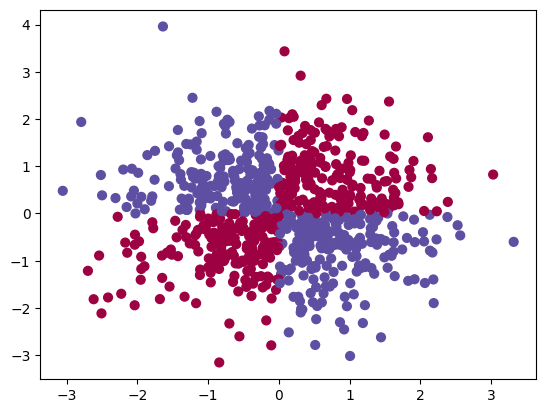

In [49]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [50]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold

# ACTIVATION FUNCTIONS
# ReLu for hidden layer
def relu(x):
  return np.maximum(0, x)

def relu_deriv(x):
  return (x > 0).astype(float)

# logistic sigmoid for output layer
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
  return sigmoid(x) * (1 - sigmoid(x))

# cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
  epsilon = 1e-14 # reduce computational instability
  return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

# training function
def train(X, Y, input_dim, hidden_dim, output_dim, epochs, learning_rate, batch_size):
  # initialize W and b
  W1 = np.random.randn(input_dim, hidden_dim) * 0.01
  b1 = np.zeros((1, hidden_dim))
  W2 = np.random.randn(hidden_dim, output_dim) * 0.01
  b2 = np.zeros((1, output_dim))

  for epoch in range(epochs):
    # shuffle the data at the beginning of each epoch
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    # perform mini-batch SGD
    for i in range(0, X.shape[0], batch_size):
      X_batch = X[i:i+batch_size]
      y_batch = Y[i:i+batch_size].reshape(-1, 1)

      # forward pass
      Z1 = np.dot(X_batch, W1) + b1
      A1 = relu(Z1) # hidden layer activation
      Z2 = np.dot(A1, W2) + b2
      A2 = sigmoid(Z2) # output layer activation

      # backward pass
      m = X_batch.shape[0]
      # output layer gradients
      dZ2 = A2 - y_batch
      dW2 = np.dot(A1.T, dZ2) / m
      db2 = np.sum(dZ2, axis=0, keepdims=True) / m
      # hidden layer gradients
      dA1 = np.dot(dZ2, W2.T)
      dZ1 = dA1 * relu_deriv(Z1)
      dW1 = np.dot(X_batch.T, dZ1) / m
      db1 = np.sum(dZ1, axis=0, keepdims=True) / m

      # update weights
      W1 -= learning_rate * dW1
      b1 -= learning_rate * db1
      W2 -= learning_rate * dW2
      b2 -= learning_rate * db2

    # check cross entropy loss for every 100 epochs
    if epoch % 100 == 0:
      loss = cross_entropy_loss(y_batch, A2)
      print(f"Epoch {epoch}, Loss: {loss:.4f}")

  return W1, b1, W2, b2

# evaluate and generate classification report
def evaluate(X, Y, W1, b1, W2, b2):
  # forward pass
  Z1 = np.dot(X, W1) + b1
  A1 = relu(Z1) # hidden layer activation
  Z2 = np.dot(A1, W2) + b2
  A2 = sigmoid(Z2) # output layer activation

  y_pred = (A2 > 0.5).astype(int)
  print(classification_report(Y, y_pred))
  print("Accuracy:", accuracy_score(Y, y_pred))

In [51]:
# parameters
input_dim = X_train.shape[1] # num of input features
hidden_dim = 10 # num of units in hidden layer
output_dim = 1 # output
lr = 0.01 # learning rate
epochs = 600
batch_size = 32

# perform cross validation, 5-fold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
acc_list = [] # store each fold's accuracy

fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {fold}")

    # split data into train and validation sets
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    # train the model using the train set
    W1, b1, W2, b2 = train(X_tr, y_tr, input_dim, hidden_dim, output_dim, epochs, lr, batch_size)

    # evaluate the model using the validation set
    Z1 = np.dot(X_val, W1) + b1
    A1 = relu(Z1) # hidden layer activation
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2) # output layer activation
    y_pred_val = (A2 > 0.5).astype(int)
    val_acc = accuracy_score(y_val, y_pred_val)
    acc_list.append(val_acc)

    # print accuracy for each fold
    print(f"Fold {fold} Accuracy: {val_acc:.4f}")
    fold += 1

# average accuracy across folds
avg_acc = np.mean(acc_list)

print(f"\nAverage Cross-Validation Accuracy: {avg_acc:.4f}")

Fold 1
Epoch 0, Loss: 0.6925
Epoch 100, Loss: 0.6849
Epoch 200, Loss: 0.6063
Epoch 300, Loss: 0.5641
Epoch 400, Loss: 0.3243
Epoch 500, Loss: 0.2691
Fold 1 Accuracy: 0.9750
Fold 2
Epoch 0, Loss: 0.6930
Epoch 100, Loss: 0.6845
Epoch 200, Loss: 0.6619
Epoch 300, Loss: 0.4634
Epoch 400, Loss: 0.2415
Epoch 500, Loss: 0.2119
Fold 2 Accuracy: 0.9750
Fold 3
Epoch 0, Loss: 0.6932
Epoch 100, Loss: 0.6926
Epoch 200, Loss: 0.6775
Epoch 300, Loss: 0.5630
Epoch 400, Loss: 0.4192
Epoch 500, Loss: 0.2884
Fold 3 Accuracy: 0.9500
Fold 4
Epoch 0, Loss: 0.6932
Epoch 100, Loss: 0.6979
Epoch 200, Loss: 0.6480
Epoch 300, Loss: 0.3752
Epoch 400, Loss: 0.2574
Epoch 500, Loss: 0.1309
Fold 4 Accuracy: 0.9812
Fold 5
Epoch 0, Loss: 0.6930
Epoch 100, Loss: 0.7008
Epoch 200, Loss: 0.6484
Epoch 300, Loss: 0.4445
Epoch 400, Loss: 0.2240
Epoch 500, Loss: 0.1618
Fold 5 Accuracy: 0.9688

Average Cross-Validation Accuracy: 0.9700


In [52]:
# train data evaluation, classification report
evaluate(X_train, y_train, W1, b1, W2, b2)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       387
           1       0.98      0.98      0.98       413

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Accuracy: 0.98125


In [53]:
# test data evaluation, classification report
evaluate(X_test, y_test, W1, b1, W2, b2)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       103

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

Accuracy: 0.995


## Summary

A two-layer neural network for binary classification is implemented. The training dataset contains 800 samples and testing data set contains 200 samples.

The model architecture include a input layer with the number of features in the input dataset, a hidden layer of 10 units using ReLU activation, and an output layer of single neuron with sigmoid activation. The loss function used is the cross-entropy loss and the optimizer used is mini-batch SGD (batch size = 32 and learning rate = 0.01). Weights and biases are initialized randomly and updated in iterations. The train function performs forward pass and backward pass, computing activations and gradients and updating weights and biases in each epoch. THe total number of epochs is 600 and loss is reported for every 100 epochs.

To evaluate the model, a forward pass is performed on a given dataset to generate predictions, then a classification report and accuracy score are generated for the purpose of assessing the model's performance on training and testing dataset. The prediction employs a threshold of 0.5 for binary classification purpose.

A 5-fold cross validation is also used to estimate model performance. For each fold, the model is evaluated on the validation portion by accuracy measures. In the end, an average validation accuracy across all folds is computed.


This two-layer neural network had good performance based on the accuracy reports for both training datset and testing dataset, respectively 98.125% and 99.5%, which are close to 100%. Based on the classification reports of both datasets, precision, recall, and F1-scores for are high as well, around 0.98–0.99. Also, the loss shows a decreasing trend as the number of epochs increases. These evaluation results show that the model is effective in the binary classification task.